In [1]:
!pip install requests

### Library

In [2]:
import pandas as pd
import numpy as np
import urllib.request
import requests
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow

###Load Dataset

In [38]:
#Load Dataset
git_url = 'https://raw.githubusercontent.com/C241-PS139/Recout-ML-API/main/ML_API/app/cleaned_dataset.csv'
ds = pd.read_csv(git_url, delimiter=',')
ds.head()

,Unnamed: 0,product_id,gender_product,temperature,usage,productDisplayName,city,link
0,0,16193,Men,Cold,Casual,Puma Men Knitted Vest Green Sweater,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
1,1,20228,Women,Cold,Casual,Wrangler Women Cable Red Sweater,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
2,2,59620,Women,Hot,Ethnic,FNF Green & Black Wedding Collection Sari,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
3,3,12282,Men,Cold,Formal,Genesis Men Green & Purple Striped Shirt,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...
4,4,53051,Women,Cold,Ethnic,FNF Maroon Printed Sari,Sulawesi Selatan,http://assets.myntassets.com/v1/images/style/p...


### API OpenWeatherMap



In [39]:
base_url = "http://api.openweathermap.org/data/2.5/weather?"
API_KEY = '5b48d68ce066834a01e3b108a9e5891a'
city = input("Masukkan Nama Provinsi : ")

url = base_url + "appid=" + API_KEY + "&q=" + city
response=requests.get(url).json()

def kelvin_to_celcius(kelvin):
  celcius = kelvin - 273.15
  return celcius

temp_kelvin=response['main']['temp']
temp_celcius=kelvin_to_celcius(temp_kelvin)
feels_like_kelvin = response['main']['feels_like']
feels_like_celcius = kelvin_to_celcius(feels_like_kelvin)

print(f"Temperature in {city}: {temp_celcius:.2f}°C")
print(f"Temperature in {city} feels like: {feels_like_celcius:.2f}°C")

Masukkan Nama Provinsi : Jawa Timur
Temperature in Jawa Timur: 15.48°C
Temperature in Jawa Timur feels like: 15.62°C



### Konversi Suhu

In [40]:
def convert_temperature(temperature):
    if temperature < 20:
        temperature = "Cold"
    elif temperature >=20 and temperature <30:
        temperature = "Normal"
    elif temperature >=30:
        temperature = "Hot"

    return temperature

temperature = convert_temperature(temp_celcius)
print(f"Musim untuk suhu {temp_celcius:.1f}°C termasuk kategori : {temperature}")


Musim untuk suhu 15.5°C termasuk kategori : Cold


### Model Cosine Similarity

Inputan = Men, Women, Boys

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


gender_product : Men


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Rekomendasi outfit Men di provinsi Jawa Timur:
       Unnamed: 0  product_id gender_product temperature   usage  \
3485         4318       15992            Men        Cold  Casual   
5025         6824       12625            Men        Cold  Casual   
7848        13309        9686            Men        Cold  Casual   
9906        20455       16908            Men        Cold  Casual   
13879       62514        7348            Men        Cold  Casual   

                             productDisplayName        city  \
3485                Turtle Check Men Blue Shirt  Jawa Timur   
5025         Probase Men Printed Orange Tshirts  Jawa Timur   
7848   ADIDAS Men Ess F Logo Navy Blue T-Shirts  Jawa Timur   
9906      Status Quo Men Solid Black Sweatshirt  Jawa Timur   
13879            Tantra Men's Help Navy T-Shirt  Jawa Timur   

                                                    link  
3485   http://assets.myntassets.com/v1/images/style/p...  
5025   http://assets.myntassets.com/v1/images/s

[9686, 7348, 15992, 16908, 12625]

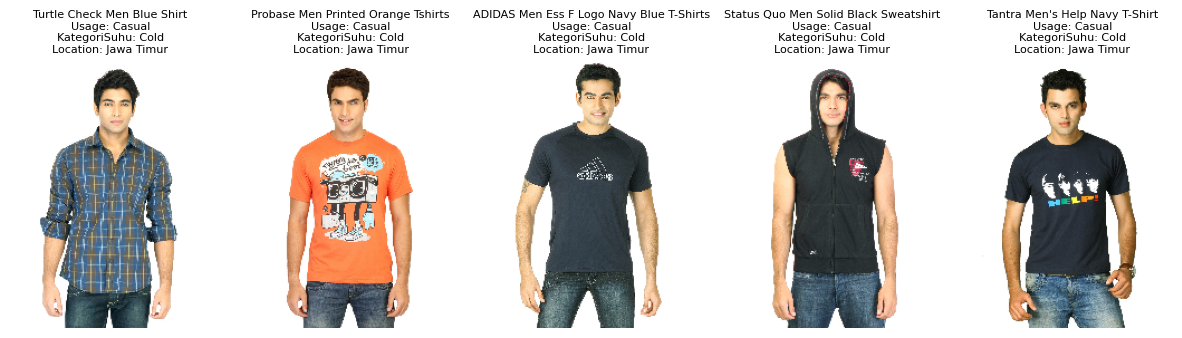

In [41]:
features = ds[['gender_product','temperature','city']]
targets = ds['product_id']

onehot_encoder = OneHotEncoder(sparse=False)
features_onehot = onehot_encoder.fit_transform(features)


def recommend_outfits(gender_product, temperature,city):

    query_vector = onehot_encoder.transform(np.array([gender_product,temperature,city]).reshape(1, -1))

    similarities = cosine_similarity(query_vector, features_onehot)

    top_n = 5
    sorted_indices = similarities.argsort()[0][-top_n:]

    recommended_outfits = targets.iloc[sorted_indices].tolist()

    print(f"Rekomendasi outfit {gender_product} di provinsi {city}:")

    filtered_df = ds[ds['product_id'].isin(recommended_outfits)].head(top_n)
    print(filtered_df)
    plt.figure(figsize=(15, 10))
    for idx, row in filtered_df.iterrows():
            req = urllib.request.urlopen(row['link'])
            image_array = np.asarray(bytearray(req.read()), dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            resized_image = cv2.resize(image, (0, 0), fx=0.1, fy=0.1)

            ax = plt.subplot(1, top_n, list(filtered_df.index).index(idx) + 1)
            plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            ax.set_title(f"{row['productDisplayName']}\nUsage: {row['usage']}\nKategoriSuhu: {row['temperature']}\nLocation: {row['city']}", fontsize=8)

    true_relevant_product_ids = all['product_id'].tolist()

    predicted_relevant_product_ids = recommended_outfits

    #Precision
    precision = len(set(true_relevant_product_ids) & set(predicted_relevant_product_ids)) / len(predicted_relevant_product_ids)

    #Recall
    recall = len(set(true_relevant_product_ids) & set(predicted_relevant_product_ids)) / len(true_relevant_product_ids)

    #MRR
    mrr = 0
    for i, product_id in enumerate(predicted_relevant_product_ids):
        if product_id in true_relevant_product_ids:
            mrr += 1 / (i + 1)

    mrr /= len(predicted_relevant_product_ids)

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"MRR: {mrr:.3f}")

    return recommended_outfits


x=input("gender_product : ")

recommend_outfits(x,temperature,city)


Parameter yang dimasukkan

1.   Gender Product
2.   Suhu
3.   home_location

- API Open Weather Map Untuk Mendeteksi Suhu
- fungsi konversi suhu masuk ke dalam kategori apa?




### Save Model to Joblib File

In [ ]:
import joblib

# Save the model (assuming 'recommend_outfits' is your model function)
joblib.dump(recommend_outfits, 'outfit_recommendation_model.joblib')

Model saved successfully as 'outfit_recommendation_model.joblib'.
